# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

# Проверка пропусков по столбцам
print("Количество пропусков по столбцам:")
missing_values = df.isnull().sum()
print(missing_values)


Количество пропусков по столбцам:
age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код

# Смотрим на уникальные значения в столбце job
print("Уникальные значения в столбце 'job':")
unique_values = df['job'].unique()
print(f"Всего уникальных значений: {len(unique_values)}")
print("Список значений:")
for value in sorted(unique_values):
    print(f"  '{value}'")
print()


Уникальные значения в столбце 'job':
Всего уникальных значений: 12
Список значений:
  'admin.'
  'blue-collar'
  'entrepreneur'
  'housemaid'
  'management'
  'retired'
  'self-employed'
  'services'
  'student'
  'technician'
  'unemployed'
  'unknown'



### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

import re

# Создаем копию для обработки
df['balance_clean'] = df['balance'].astype(str)

# Применяем регулярные выражения для очистки данных
# 1. Удаляем лишние пробелы в начале и конце
df['balance_clean'] = df['balance_clean'].str.strip()

# 2. Заменяем запятые на точки (для европейского формата чисел)
df['balance_clean'] = df['balance_clean'].str.replace(',', '.', regex=False)

# 3. Удаляем все символы кроме цифр, точек
df['balance_clean'] = df['balance_clean'].apply(lambda x: re.sub(r'[^\d.-]', '', str(x)))

# 4. Исправляем случаи с несколькими точками - оставляем только первую
df['balance_clean'] = df['balance_clean'].apply(lambda x: re.sub(r'\.(?=.*\.)', '', str(x)))

# 5. Убираем знаки минус не в начале числа
df['balance_clean'] = df['balance_clean'].apply(lambda x: re.sub(r'(?<!^)-', '', str(x)))

# Преобразуем в числовой формат
df['balance'] = pd.to_numeric(df['balance_clean'], errors='coerce')

# Удаляем временный столбец
df.drop('balance_clean', axis=1, inplace=True)

# Проверяем результат
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

# Вычислим медианное значение (только для непропущенных значений)
median_balance = df['balance'].median()
print(f"Медианное значение столбца 'balance': {median_balance}")
print()

# Заменяем пропуски на медианное значение
df['balance'].fillna(median_balance, inplace=True)

# Проверим результат после обработки
print(f"Количество пропусков: {df['balance'].isnull().sum()}")

# Покажем описательную статистику после заполнения
print(df['balance'].describe())

Медианное значение столбца 'balance': 550.0

Количество пропусков: 0
count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64


### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

# скрытые пропуски в виде 'unknown', заменим их на NaN
# Сначала для столбца 'job'
if 'unknown' in df['job'].values:
    df['job'] = df['job'].replace('unknown', np.nan)

# Для столбца 'education' 
if 'unknown' in df['education'].values:
    df['education'] = df['education'].replace('unknown', np.nan)

# Найдем модальные значения (наиболее часто встречающиеся)
mode_job = df['job'].mode()[0]  # mode() возвращает Series, берем первый элемент
mode_education = df['education'].mode()[0]

print("Модальные значения:")
print(f"Мода для 'job': {mode_job}")
print(f"Мода для 'education': {mode_education}")

# заполнение пропусков модальными значениями
df['education'].fillna(df['education'].mode()[0], inplace=True)
df['job'].fillna(df['job'].mode()[0], inplace=True)

print("Пропуски заполнены модальными значениями")
print(f"education пропусков: {df['education'].isnull().sum()}")
print(f"job пропусков: {df['job'].isnull().sum()}")

Модальные значения:
Мода для 'job': management
Мода для 'education': secondary
Пропуски заполнены модальными значениями
education пропусков: 0
job пропусков: 0


In [8]:
# Рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования

# Находим самую популярную работу
most_popular_job = df['job'].value_counts().index[0]
print(f"Самая популярная работа: {most_popular_job}")
print(f"Количество клиентов с этой работой: {df['job'].value_counts().iloc[0]}")
print()

# Находим самый популярный уровень образования
most_popular_education = df['education'].value_counts().index[0]
print(f"Самый популярный уровень образования: {most_popular_education}")
print(f"Количество клиентов с этим образованием: {df['education'].value_counts().iloc[0]}")
print()

# Фильтруем клиентов с одновременно самой популярной работой и самым популярным образованием
target_clients = df[(df['job'] == most_popular_job) & (df['education'] == most_popular_education)]

print(f"Количество клиентов с самой популярной работой И самым популярным образованием: {len(target_clients)}")
print()

# Рассчитываем средний баланс для этих клиентов
if len(target_clients) > 0:
    average_balance = target_clients['balance'].mean()
    
    print(f"Средний баланс для клиентов с '{most_popular_job}' и '{most_popular_education}':")
    print(f"Точное значение: {average_balance}")
    print(f"Округленное до 3 знаков после запятой: {round(average_balance, 3)}")
    
    # Дополнительная статистика
    print(f"\nДополнительная статистика для этой группы:")
    print(f"Минимальный баланс: {target_clients['balance'].min()}")
    print(f"Максимальный баланс: {target_clients['balance'].max()}")
    print(f"Медианный баланс: {target_clients['balance'].median()}")
    print(f"Стандартное отклонение: {target_clients['balance'].std():.3f}")
else:
    print("Не найдено клиентов с такой комбинацией работы и образования")

# Альтернативный способ в одну строку
answer = df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean()
print(f"\nОтвет (в одну строку): {round(answer, 3)}")

Самая популярная работа: management
Количество клиентов с этой работой: 2636

Самый популярный уровень образования: secondary
Количество клиентов с этим образованием: 5973

Количество клиентов с самой популярной работой И самым популярным образованием: 376

Средний баланс для клиентов с 'management' и 'secondary':
Точное значение: 1598.8829787234042
Округленное до 3 знаков после запятой: 1598.883

Дополнительная статистика для этой группы:
Минимальный баланс: -994.0
Максимальный баланс: 19268.0
Медианный баланс: 703.0
Стандартное отклонение: 2440.042

Ответ (в одну строку): 1598.883


### Задание 6

In [9]:
# удалите все выбросы для признака balance
# ваш код

# Метод Тьюки для поиска выбросов
print("Анализ выбросов для признака 'balance' методом Тьюки")
print("=" * 60)

# Вычисляем квартили и межквартильный размах (IQR)
Q1 = df['balance'].quantile(0.25)  # Нижний квартиль (25-й процентиль)
Q3 = df['balance'].quantile(0.75)  # Верхний квартиль (75-й процентиль)
IQR = Q3 - Q1  # Межквартильный размах

print(f"Первый квартиль (Q1): {Q1:.2f}")
print(f"Третий квартиль (Q3): {Q3:.2f}")
print(f"Межквартильный размах (IQR): {IQR:.2f}")
print()

# Вычисляем границы по методу Тьюки (1.5 * IQR)
lower_bound = Q1 - 1.5 * IQR  # Нижняя граница
upper_bound = Q3 + 1.5 * IQR  # Верхняя граница

print("Границы для определения выбросов:")
print(f"Нижняя граница: {lower_bound:.2f} (округленно: {round(lower_bound)})")
print(f"Верхняя граница: {upper_bound:.2f} (округленно: {round(upper_bound)})")
print()

# Подсчитываем количество выбросов
outliers_mask = (df['balance'] < lower_bound) | (df['balance'] > upper_bound)
outliers_count = outliers_mask.sum()
total_records = len(df)

print(f"Количество выбросов: {outliers_count} из {total_records} записей ({outliers_count/total_records*100:.2f}%)")
print()

# Показываем статистику до удаления выбросов
print("Статистика balance ДО удаления выбросов:")
print(df['balance'].describe())
print()

# Удаляем выбросы
df_cleaned = df[~outliers_mask].copy()
print(f"Размер данных до удаления выбросов: {df.shape}")
print(f"Размер данных после удаления выбросов: {df_cleaned.shape}")
print(f"Удалено записей: {df.shape[0] - df_cleaned.shape[0]}")
print()

# Показываем статистику после удаления выбросов
print("Статистика balance ПОСЛЕ удаления выбросов:")
print(df_cleaned['balance'].describe())
print()

# Обновляем основной DataFrame
df = df_cleaned.copy()

print("=" * 60)
print("ОТВЕТ:")
print(f"Нижняя граница (округленно): {round(lower_bound)}")
print(f"Верхняя граница (округленно): {round(upper_bound)}")
print("=" * 60)

Анализ выбросов для признака 'balance' методом Тьюки
Первый квартиль (Q1): 123.00
Третий квартиль (Q3): 1699.00
Межквартильный размах (IQR): 1576.00

Границы для определения выбросов:
Нижняя граница: -2241.00 (округленно: -2241)
Верхняя граница: 4063.00 (округленно: 4063)

Количество выбросов: 1057 из 11162 записей (9.47%)

Статистика balance ДО удаления выбросов:
count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

Размер данных до удаления выбросов: (11162, 17)
Размер данных после удаления выбросов: (10105, 17)
Удалено записей: 1057

Статистика balance ПОСЛЕ удаления выбросов:
count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

ОТВЕТ:
Нижняя граница (округленно): -2241
Верхняя гра

## Часть 2:  Разведывательный анализ

### Задание 1

Процентное соотношение классов:
no: 53.68%
yes: 46.32%



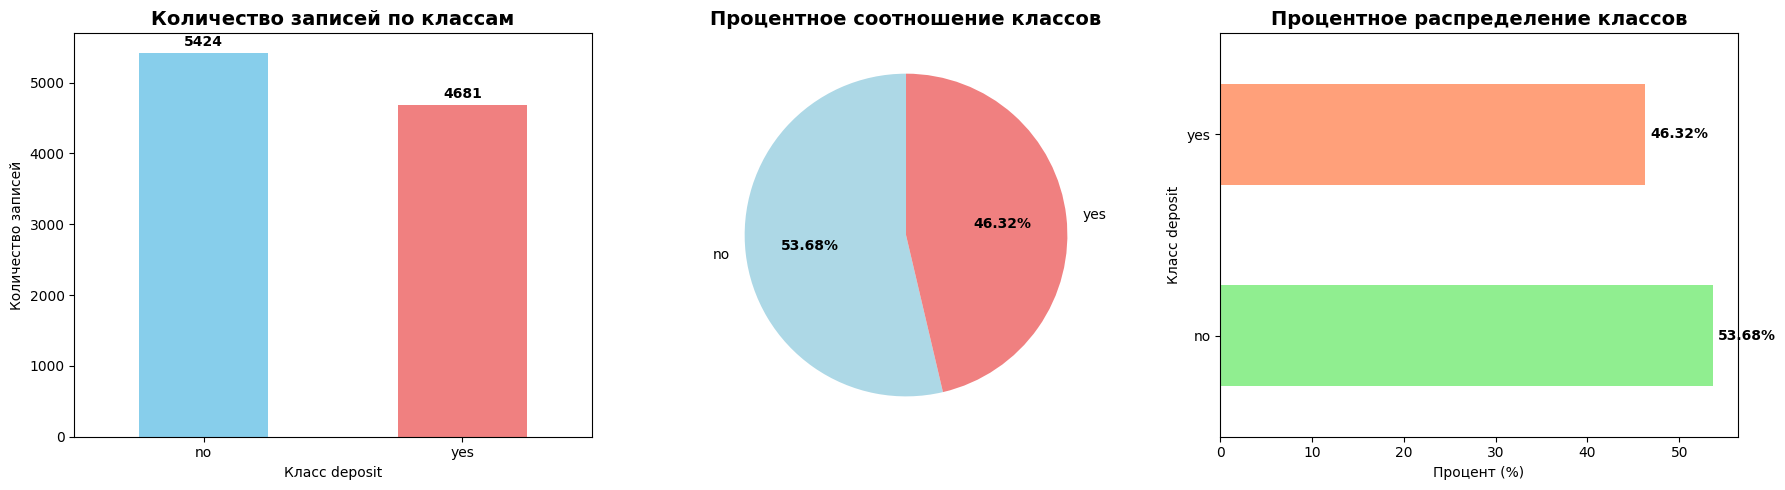

In [10]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

# Вычисляем процентное соотношение
class_counts = df['deposit'].value_counts()
class_percentage = df['deposit'].value_counts(normalize=True) * 100
print("Процентное соотношение классов:")
for class_label, percentage in class_percentage.items():
    print(f"{class_label}: {percentage:.2f}%")
print()

# Оценка сбалансированности
minority_class_percentage = min(class_percentage)
majority_class_percentage = max(class_percentage)
imbalance_ratio = majority_class_percentage / minority_class_percentage

# Создаем визуализации
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Столбчатая диаграмма
class_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Количество записей по классам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Класс deposit')
axes[0].set_ylabel('Количество записей')
axes[0].tick_params(axis='x', rotation=0)

# Добавляем значения на столбцы
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + max(class_counts.values) * 0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')

# 2. Круговая диаграмма
colors = ['lightblue', 'lightcoral']
wedges, texts, autotexts = axes[1].pie(class_counts.values, 
                                      labels=class_counts.index,
                                      autopct='%1.2f%%',
                                      colors=colors,
                                      startangle=90)
axes[1].set_title('Процентное соотношение классов', fontsize=14, fontweight='bold')

# Делаем текст на диаграмме более читаемым
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

# 3. Горизонтальная столбчатая диаграмма с процентами
class_percentage.plot(kind='barh', ax=axes[2], color=['lightgreen', 'lightsalmon'])
axes[2].set_title('Процентное распределение классов', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Процент (%)')
axes[2].set_ylabel('Класс deposit')

# Добавляем значения на столбцы
for i, v in enumerate(class_percentage.values):
    axes[2].text(v + max(class_percentage.values) * 0.01, i, f'{v:.2f}%', 
                ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Задания 2 и 3

Количественные переменные: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

ОСНОВНЫЕ ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:
            age   balance       day  duration  campaign     pdays  previous
count  10105.00  10105.00  10105.00  10105.00  10105.00  10105.00  10105.00
mean      40.90    807.65     15.59    368.74      2.52     51.32      0.82
std       11.73    994.15      8.44    346.65      2.71    109.64      2.24
min       18.00  -2049.00      1.00      2.00      1.00     -1.00      0.00
25%       32.00     95.00      8.00    137.00      1.00     -1.00      0.00
50%       38.00    445.00     15.00    252.00      2.00     -1.00      0.00
75%       48.00   1227.00     22.00    490.00      3.00      2.00      1.00
max       95.00   4063.00     31.00   3881.00     43.00    854.00     58.00

ПОДРОБНЫЙ АНАЛИЗ ПО КАЖДОЙ ПЕРЕМЕННОЙ:

 ПЕРЕМЕННАЯ: AGE
--------------------------------------------------
 Меры центральной тенденции:
   • Среднее: 40.90
   • Медиана: 38.00
   • 

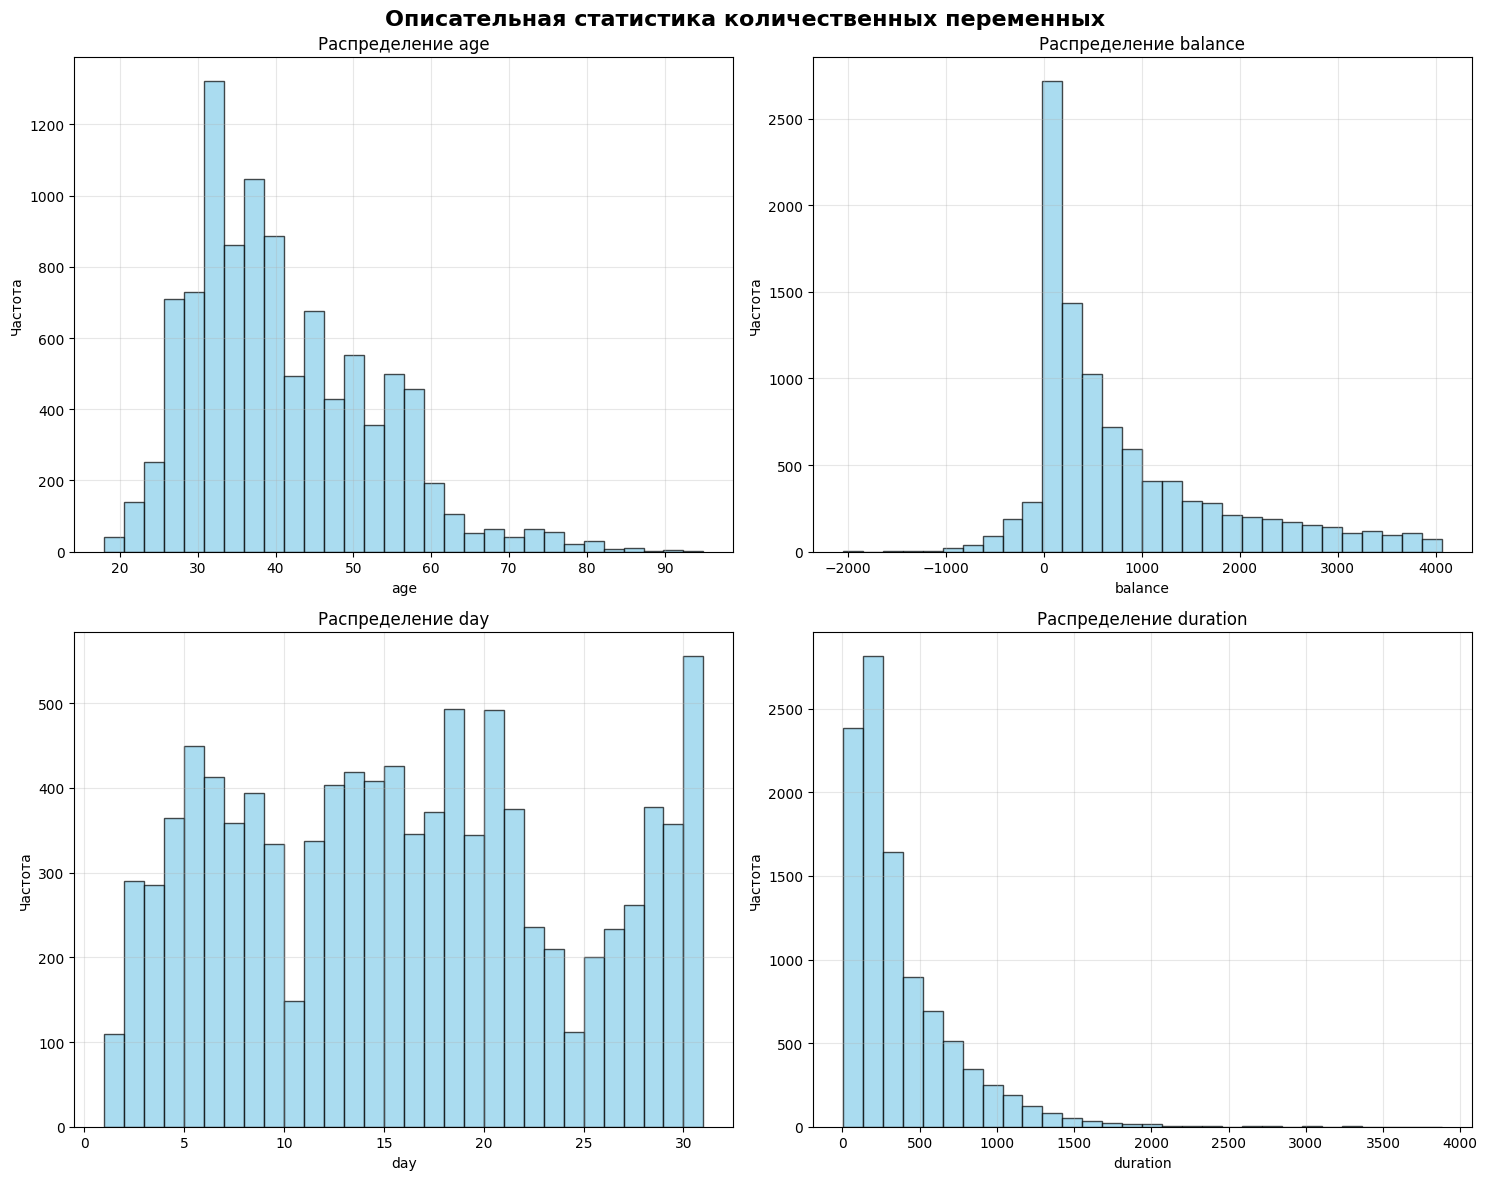

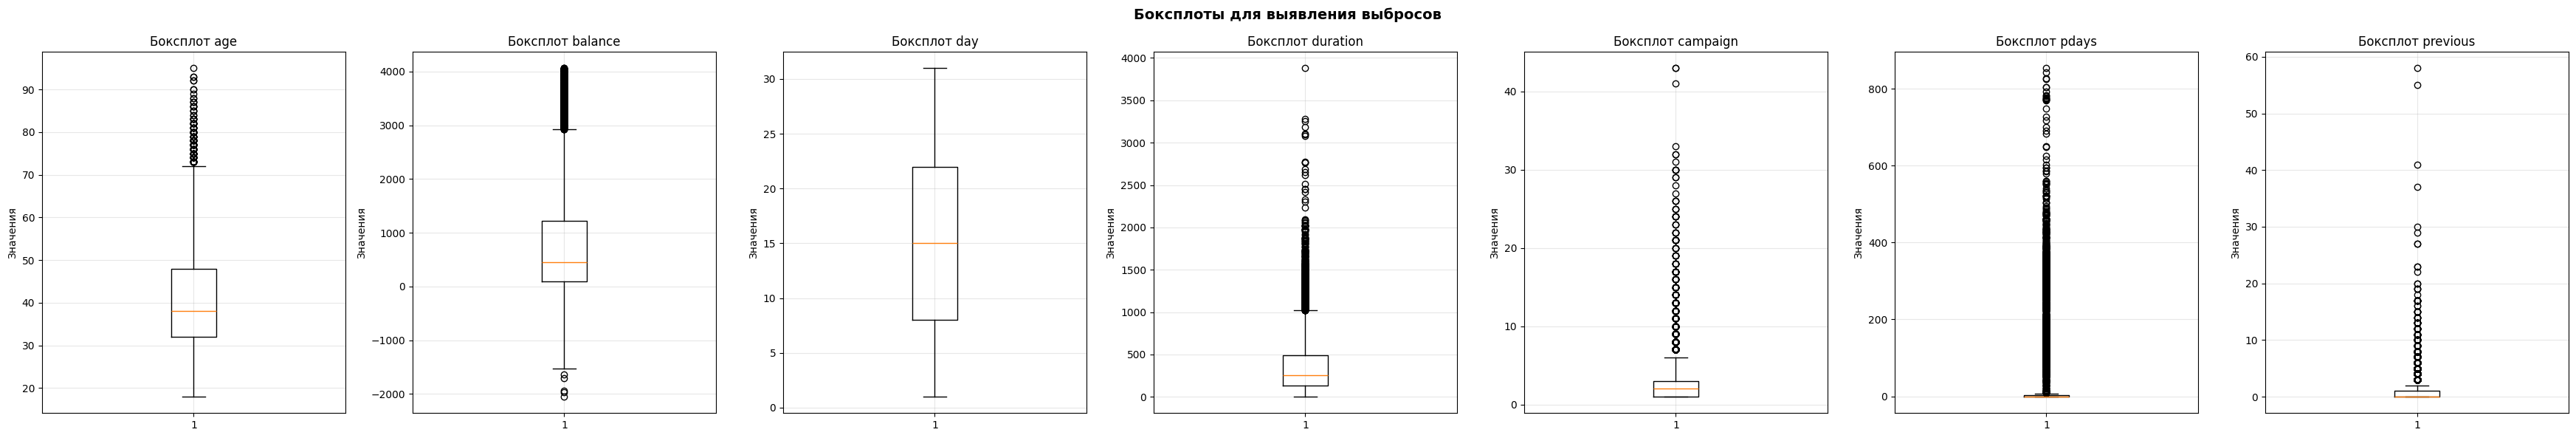

In [11]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

# Определяем количественные переменные
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Количественные переменные: {numeric_columns}")
print()

# Основные описательные статистики
desc_stats = df[numeric_columns].describe()
print("ОСНОВНЫЕ ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:")
print(desc_stats.round(2))
print()

# Дополнительные меры для каждой переменной
print("ПОДРОБНЫЙ АНАЛИЗ ПО КАЖДОЙ ПЕРЕМЕННОЙ:")
print("=" * 80)

for col in numeric_columns:
    print(f"\n ПЕРЕМЕННАЯ: {col.upper()}")
    print("-" * 50)
    
    data = df[col]
    
    # Основные статистики
    mean_val = data.mean()
    median_val = data.median()
    mode_val = data.mode().iloc[0] if len(data.mode()) > 0 else "Нет моды"
    std_val = data.std()
    var_val = data.var()
    min_val = data.min()
    max_val = data.max()
    range_val = max_val - min_val
    
    # Квартили и межквартильный размах
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    
    # Коэффициент вариации
    cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
    
    # Асимметрия и эксцесс
    skewness = data.skew()
    kurtosis = data.kurtosis()
    
    print(f" Меры центральной тенденции:")
    print(f"   • Среднее: {mean_val:.2f}")
    print(f"   • Медиана: {median_val:.2f}")
    print(f"   • Мода: {mode_val}")
    
    print(f"\n Меры разброса:")
    print(f"   • Стандартное отклонение: {std_val:.2f}")
    print(f"   • Дисперсия: {var_val:.2f}")
    print(f"   • Размах: {range_val:.2f} (от {min_val:.2f} до {max_val:.2f})")
    print(f"   • Межквартильный размах (IQR): {iqr:.2f}")
    print(f"   • Коэффициент вариации: {cv:.2f}%")
    
    print(f"\n Распределение:")
    print(f"   • Асимметрия (skewness): {skewness:.3f}")
    print(f"   • Эксцесс (kurtosis): {kurtosis:.3f}")
    
    # Интерпретация асимметрии
    if abs(skewness) < 0.5:
        skew_interp = "практически симметричное"
    elif skewness > 0.5:
        skew_interp = "правосторонняя асимметрия (длинный правый хвост)"
    else:
        skew_interp = "левосторонняя асимметрия (длинный левый хвост)"
    
    # Интерпретация эксцесса
    if abs(kurtosis) < 0.5:
        kurt_interp = "нормальная островершинность"
    elif kurtosis > 0.5:
        kurt_interp = "высокая островершинность (толстые хвосты)"
    else:
        kurt_interp = "низкая островершинность (тонкие хвосты)"
    
    print(f"\n💡 Интерпретация распределения:")
    print(f"   • {skew_interp}")
    print(f"   • {kurt_interp}")
    
    # Анализ вариативности
    print(f"\n Анализ вариативности:")
    if cv < 15:
        var_level = "низкая"
    elif cv < 35:
        var_level = "умеренная"
    else:
        var_level = "высокая"
    print(f"   • Вариативность данных: {var_level} ({cv:.1f}%)")
    
    # Сравнение мер центральной тенденции
    print(f"\n Сравнение мер центральной тенденции:")
    diff_mean_median = abs(mean_val - median_val)
    if diff_mean_median / std_val < 0.2:
        central_tendency = "Среднее ≈ медиана → симметричное распределение"
    elif mean_val > median_val:
        central_tendency = "Среднее > медиана → возможны выбросы справа (большие значения)"
    else:
        central_tendency = "Среднее < медиана → возможны выбросы слева (малые значения)"
    print(f"   • {central_tendency}")
    
    # Потенциальные выбросы по правилу 3 сигм
    lower_3sigma = mean_val - 3 * std_val
    upper_3sigma = mean_val + 3 * std_val
    outliers_3sigma = ((data < lower_3sigma) | (data > upper_3sigma)).sum()
    
    print(f"\n Потенциальные выбросы (правило 3σ):")
    print(f"   • Границы: [{lower_3sigma:.2f}, {upper_3sigma:.2f}]")
    print(f"   • Количество потенциальных выбросов: {outliers_3sigma}")
    
    print("-" * 50)

# Корреляционный анализ
print(f"\n\n КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")
print("=" * 50)
correlation_matrix = df[numeric_columns].corr()
print("Матрица корреляций:")
print(correlation_matrix.round(3))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Описательная статистика количественных переменных', fontsize=16, fontweight='bold')

# 1. Гистограммы
for i, col in enumerate(numeric_columns):
    row = i // 2
    col_idx = i % 2
    if i < 4:  # максимум 4 графика
        axes[row, col_idx].hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[row, col_idx].set_title(f'Распределение {col}')
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Частота')
        axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Боксплоты для выявления выбросов
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(5*len(numeric_columns), 6))
if len(numeric_columns) == 1:
    axes = [axes]

for i, col in enumerate(numeric_columns):
    axes[i].boxplot(df[col])
    axes[i].set_title(f'Боксплот {col}')
    axes[i].set_ylabel('Значения')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Боксплоты для выявления выбросов', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Задания 4 и 5

Категориальные переменные: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

ПОДРОБНЫЙ АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:

 ПЕРЕМЕННАЯ: JOB
------------------------------------------------------------
 Основная статистика:
   • Общее количество записей: 10105
   • Количество уникальных значений: 11
   • Наиболее частое значение (мода): management

 Частотное распределение:
Значение             Количество   Процент   
---------------------------------------------
management           2315         22.91%
blue-collar          1807         17.88%
technician           1638         16.21%
admin.               1246         12.33%
services             868          8.59%
retired              663          6.56%
self-employed        358          3.54%
unemployed           332          3.29%
student              326          3.23%
entrepreneur         300          2.97%
housemaid            252          2.49%

 Интерпретация переменной 'job':


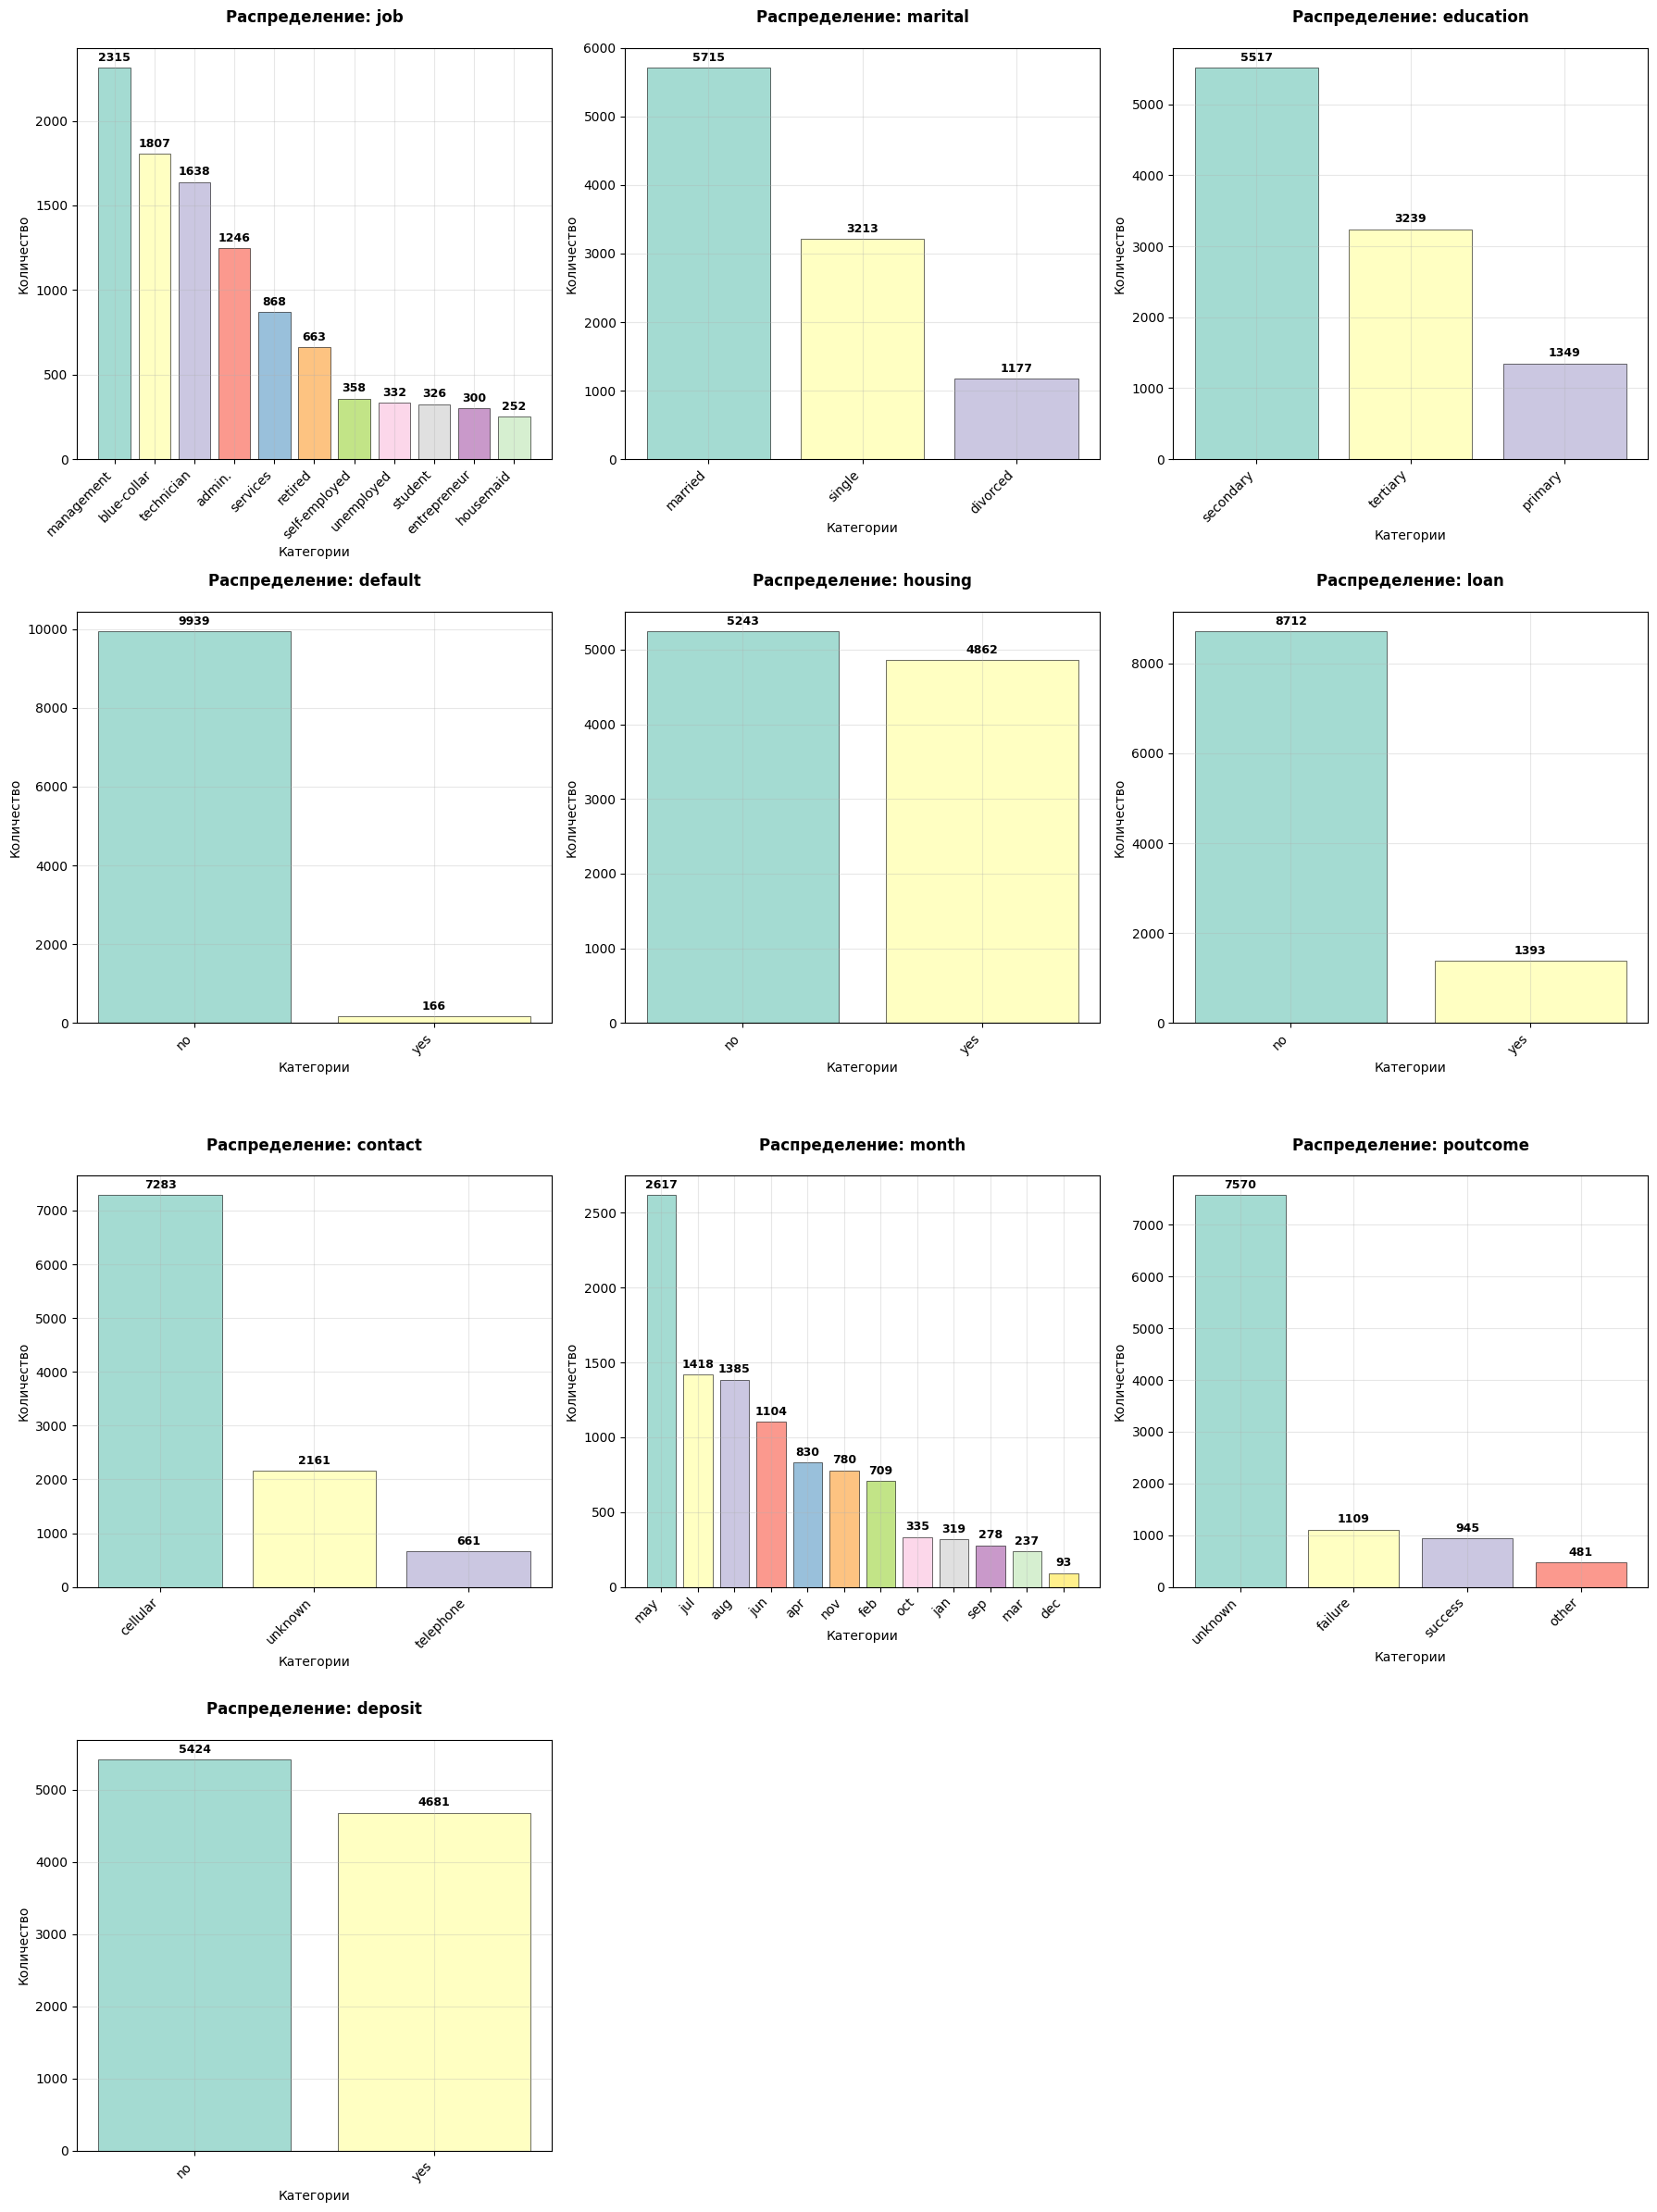

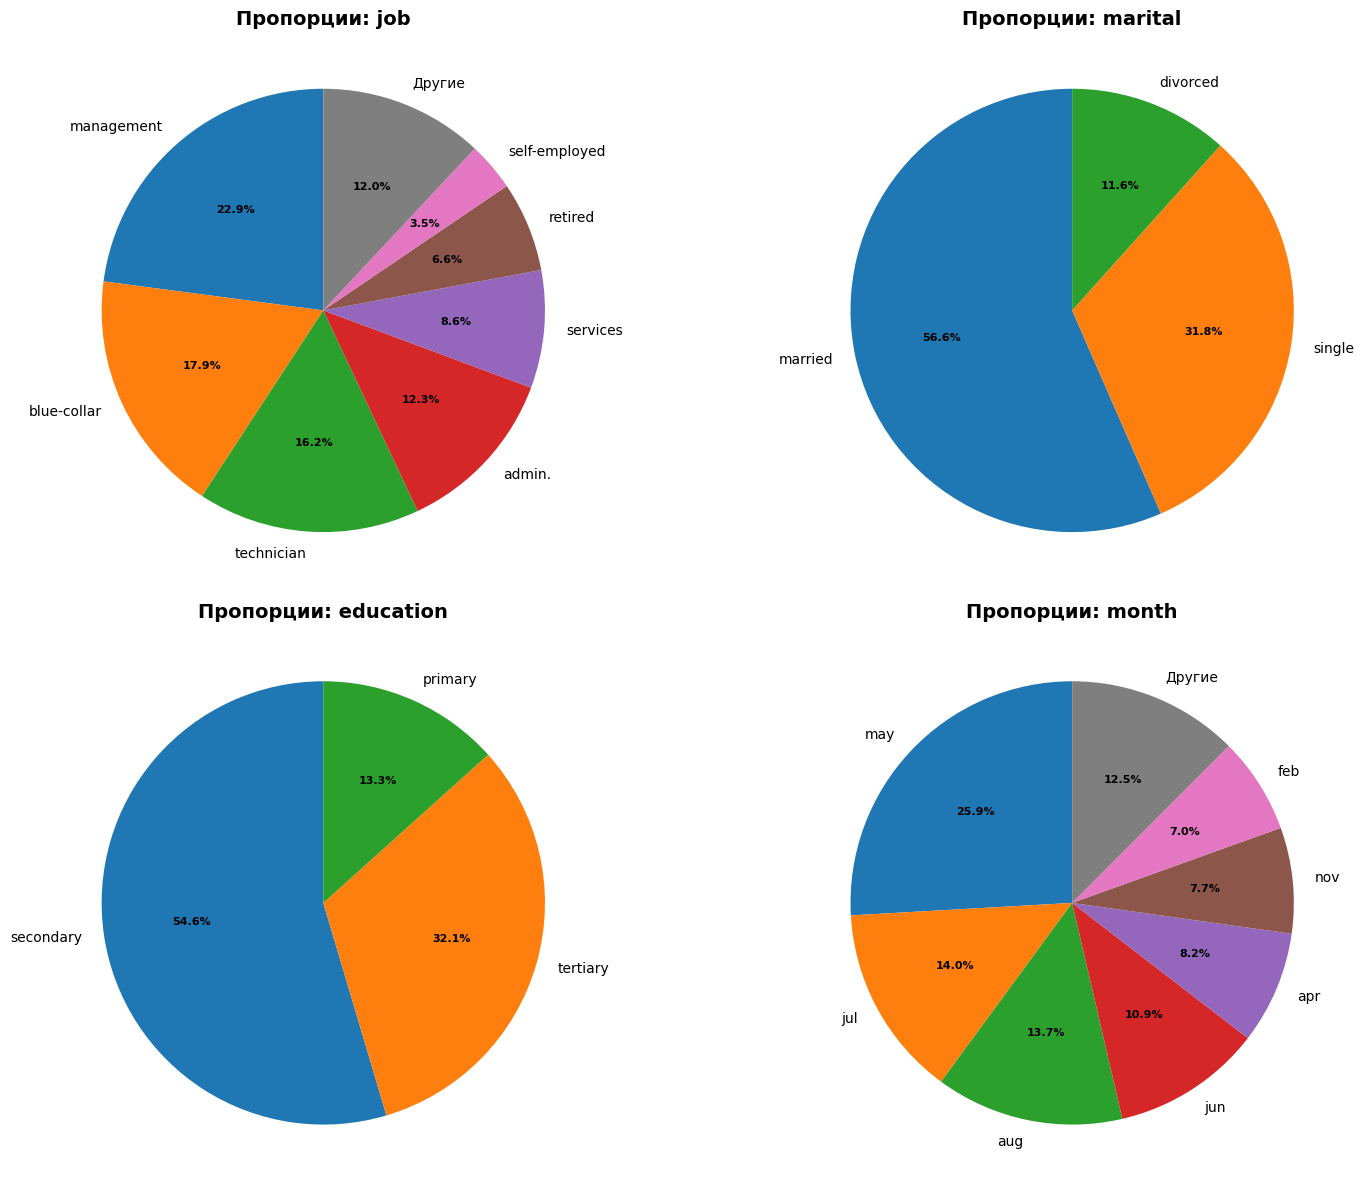



 КЛЮЧЕВЫЕ ВЫВОДЫ ПО КАТЕГОРИАЛЬНЫМ ПЕРЕМЕННЫМ:
 ПРОФЕССИИ: Представлено 11 сфер занятости, лидирует 'management'
 КАМПАНИИ: Маркетинговые кампании проводились круглогодично (12 месяцев)
 СЕМЕЙНОЕ ПОЛОЖЕНИЕ: Чаще всего встречается 'married' (56.6%)
 ОБРАЗОВАНИЕ: Преобладает 'secondary' (54.6%)


In [12]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

# Определяем категориальные переменные
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные переменные: {categorical_columns}")
print()

# Подробный анализ каждой категориальной переменной
print("ПОДРОБНЫЙ АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:")
print("=" * 80)

for col in categorical_columns:
    print(f"\n ПЕРЕМЕННАЯ: {col.upper()}")
    print("-" * 60)
    
    # Основная статистика
    unique_count = df[col].nunique()
    total_count = len(df[col])
    mode_value = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else "Нет моды"
    
    print(f" Основная статистика:")
    print(f"   • Общее количество записей: {total_count}")
    print(f"   • Количество уникальных значений: {unique_count}")
    print(f"   • Наиболее частое значение (мода): {mode_value}")
    
    # Частотное распределение
    value_counts = df[col].value_counts()
    value_percentages = df[col].value_counts(normalize=True) * 100
    
    print(f"\n Частотное распределение:")
    print(f"{'Значение':<20} {'Количество':<12} {'Процент':<10}")
    print("-" * 45)
    for value, count in value_counts.items():
        percentage = value_percentages[value]
        print(f"{str(value):<20} {count:<12} {percentage:.2f}%")
    
    # Специфичная интерпретация для каждой переменной
    print(f"\n Интерпретация переменной '{col}':")
    
    if col == 'job':
        print(f"   • В банке представлены клиенты из {unique_count} различных сфер занятости")
        print(f"   • Наиболее распространенная профессия: {mode_value}")
        print(f"   • Профессиональное разнообразие клиентской базы довольно широкое")
        
        # Топ-5 профессий
        top_jobs = value_counts.head()
        print(f"   • ТОП-5 профессий:")
        for i, (job, count) in enumerate(top_jobs.items(), 1):
            print(f"     {i}. {job}: {count} чел. ({value_percentages[job]:.1f}%)")
    
    elif col == 'marital':
        print(f"   • Представлены {unique_count} категории семейного положения")
        print(f"   • Наиболее частое семейное положение: {mode_value}")
        if value_counts.iloc[0] / total_count > 0.5:
            print(f"   • Явное преобладание одной категории ({value_percentages.iloc[0]:.1f}%)")
        else:
            print(f"   • Относительно равномерное распределение по категориям")
    
    elif col == 'education':
        print(f"   • В базе представлены {unique_count} уровня образования")
        print(f"   • Наиболее распространенный уровень образования: {mode_value}")
        print(f"   • Образовательная структура клиентов:")
        for edu, percentage in value_percentages.items():
            if percentage > 10:
                print(f"     - {edu}: {percentage:.1f}% (значительная доля)")
            else:
                print(f"     - {edu}: {percentage:.1f}%")
    
    elif col == 'default':
        print(f"   • Переменная показывает наличие кредитных дефолтов")
        print(f"   • Наиболее частое значение: {mode_value}")
        if 'yes' in value_counts.index:
            default_rate = value_percentages['yes']
            print(f"   • Доля клиентов с дефолтами: {default_rate:.2f}%")
        else:
            print(f"   • Доля клиентов с дефолтами: 0%")
    
    elif col == 'housing':
        print(f"   • Переменная отражает наличие жилищного кредита")
        if 'yes' in value_counts.index:
            housing_rate = value_percentages['yes']
            print(f"   • Доля клиентов с жилищным кредитом: {housing_rate:.2f}%")
    
    elif col == 'loan':
        print(f"   • Переменная показывает наличие персонального кредита")
        if 'yes' in value_counts.index:
            loan_rate = value_percentages['yes']
            print(f"   • Доля клиентов с персональным кредитом: {loan_rate:.2f}%")
    
    elif col == 'contact':
        print(f"   • Способы связи с клиентами: {unique_count} типа")
        print(f"   • Основной способ связи: {mode_value}")
    
    elif col == 'month':
        print(f"   • Маркетинговые кампании проводились в {unique_count} месяцах")
        if unique_count == 12:
            print(f"   • Кампании проходили круглогодично")
        else:
            print(f"   • Кампании проходили не во все месяцы года")
            months_with_campaigns = list(value_counts.index)
            print(f"   • Месяцы с кампаниями: {', '.join(months_with_campaigns)}")
            
        # Наиболее/наименее активные месяцы
        most_active = value_counts.index[0]
        least_active = value_counts.index[-1]
        print(f"   • Наиболее активный месяц: {most_active} ({value_counts[most_active]} кампаний)")
        print(f"   • Наименее активный месяц: {least_active} ({value_counts[least_active]} кампаний)")
    
    elif col == 'poutcome':
        print(f"   • Результаты предыдущих маркетинговых кампаний: {unique_count} типа")
        print(f"   • Наиболее частый результат: {mode_value}")
        if 'success' in value_counts.index:
            success_rate = value_percentages['success']
            print(f"   • Доля успешных предыдущих кампаний: {success_rate:.2f}%")
    
    elif col == 'deposit':
        print(f"   • Целевая переменная - открытие депозита")
        if 'yes' in value_counts.index:
            deposit_rate = value_percentages['yes']
            print(f"   • Конверсия (доля открывших депозит): {deposit_rate:.2f}%")
            print(f"   • Эффективность маркетинговой кампании: {'высокая' if deposit_rate > 50 else 'средняя' if deposit_rate > 20 else 'низкая'}")
    
    print("-" * 60)

# Создание визуализаций для всех категориальных переменных
print(f"\n\n ВИЗУАЛИЗАЦИИ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ")
print("=" * 60)

# Определяем количество строк и столбцов для subplot
n_vars = len(categorical_columns)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten() if n_vars > 1 else [axes]

# Цветовая палитра
colors = plt.cm.Set3(np.linspace(0, 1, 12))

for i, col in enumerate(categorical_columns):
    if i < len(axes):
        value_counts = df[col].value_counts()
        
        # Выбираем цвета для каждой переменной
        col_colors = colors[:len(value_counts)]
        
        # Создаем столбчатую диаграмму
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=col_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        axes[i].set_title(f'Распределение: {col}', fontsize=12, fontweight='bold', pad=20)
        axes[i].set_xlabel('Категории')
        axes[i].set_ylabel('Количество')
        
        # Настройка меток на оси X
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
        
        # Добавляем значения на столбцы
        for bar, value in zip(bars, value_counts.values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + max(value_counts)*0.01,
                        f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        axes[i].grid(True, alpha=0.3)

# Убираем лишние subplot'ы
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Круговые диаграммы для ключевых переменных
key_vars = ['job', 'marital', 'education', 'month']
key_vars = [var for var in key_vars if var in categorical_columns]

if key_vars:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(key_vars[:4]):
        value_counts = df[col].value_counts()
        
        # Ограничиваем количество категорий для читаемости
        if len(value_counts) > 8:
            top_values = value_counts.head(7)
            other_count = value_counts.tail(-7).sum()
            if other_count > 0:
                top_values['Другие'] = other_count
            value_counts = top_values
        
        wedges, texts, autotexts = axes[i].pie(value_counts.values, 
                                              labels=value_counts.index,
                                              autopct='%1.1f%%',
                                              startangle=90)
        
        axes[i].set_title(f'Пропорции: {col}', fontsize=14, fontweight='bold')
        
        # Улучшаем читаемость текста
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(8)
    
    plt.tight_layout()
    plt.show()

# Итоговые выводы
print(f"\n\n КЛЮЧЕВЫЕ ВЫВОДЫ ПО КАТЕГОРИАЛЬНЫМ ПЕРЕМЕННЫМ:")
print("=" * 80)

# Анализ профессий
if 'job' in df.columns:
    job_count = df['job'].nunique()
    top_job = df['job'].mode().iloc[0]
    print(f" ПРОФЕССИИ: Представлено {job_count} сфер занятости, лидирует '{top_job}'")

# Анализ месяцев
if 'month' in df.columns:
    month_count = df['month'].nunique()
    if month_count == 12:
        print(f" КАМПАНИИ: Маркетинговые кампании проводились круглогодично ({month_count} месяцев)")
    else:
        print(f"  КАМПАНИИ: Кампании проводились только в {month_count} месяцах из 12")

# Анализ семейного положения
if 'marital' in df.columns:
    top_marital = df['marital'].mode().iloc[0]
    marital_pct = (df['marital'].value_counts(normalize=True).iloc[0] * 100)
    print(f" СЕМЕЙНОЕ ПОЛОЖЕНИЕ: Чаще всего встречается '{top_marital}' ({marital_pct:.1f}%)")

# Анализ образования
if 'education' in df.columns:
    top_education = df['education'].mode().iloc[0]
    edu_pct = (df['education'].value_counts(normalize=True).iloc[0] * 100)
    print(f" ОБРАЗОВАНИЕ: Преобладает '{top_education}' ({edu_pct:.1f}%)")

### Задание 6

<Axes: xlabel='count', ylabel='poutcome'>

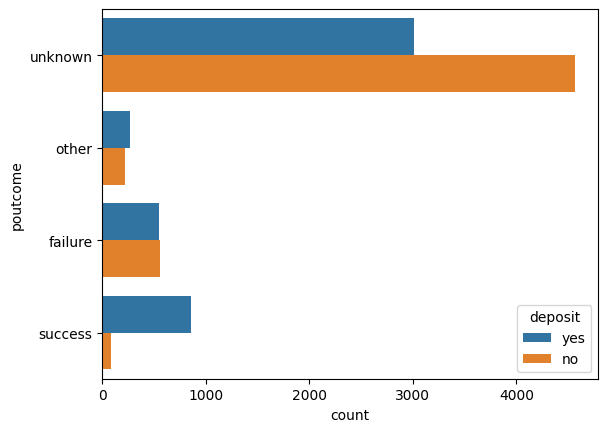

In [13]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
sns.countplot(y = 'poutcome', hue='deposit', data=df)

### Задание 7

<Axes: xlabel='count', ylabel='month'>

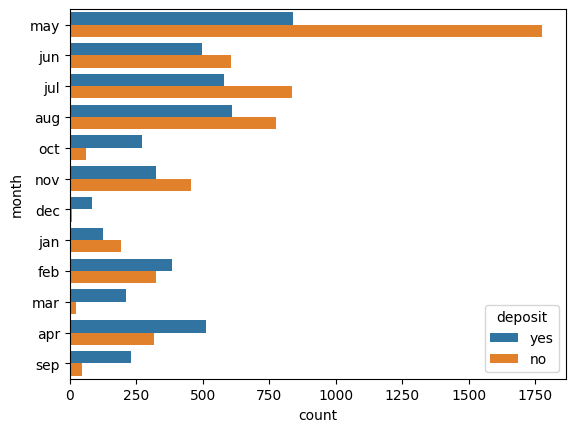

In [14]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

sns.countplot(y = 'month', hue='deposit', data=df)

### Задание 8

<Axes: xlabel='count', ylabel='age_group'>

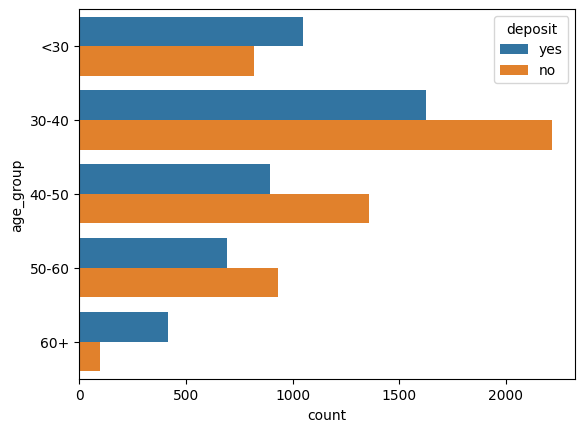

In [15]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

df['age_group'] = pd.cut(df.age, [0, 30, 40, 50, 60, 9999], labels=['<30', '30-40', '40-50', '50-60', '60+'])
sns.countplot(y = 'age_group', hue='deposit', data=df)

### Задания 9 и 10

<Axes: xlabel='count', ylabel='marital'>

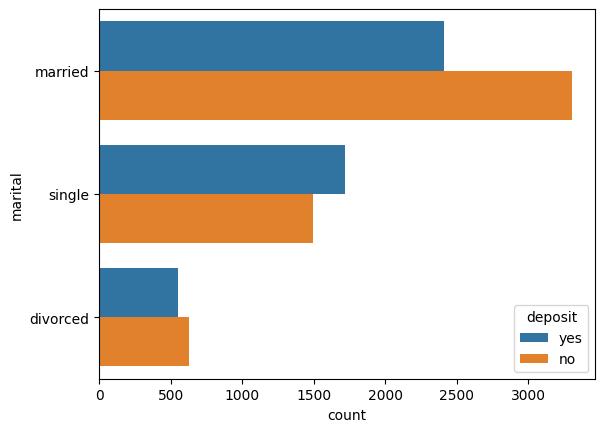

In [16]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y = 'marital', hue='deposit', data=df)

<Axes: xlabel='count', ylabel='education'>

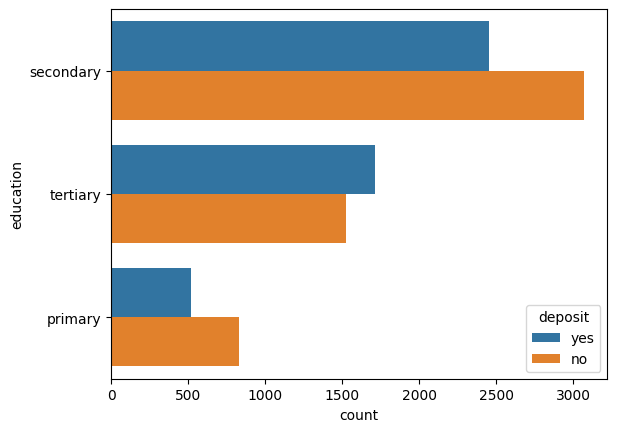

In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y = 'education', hue='deposit', data=df)

<Axes: xlabel='count', ylabel='job'>

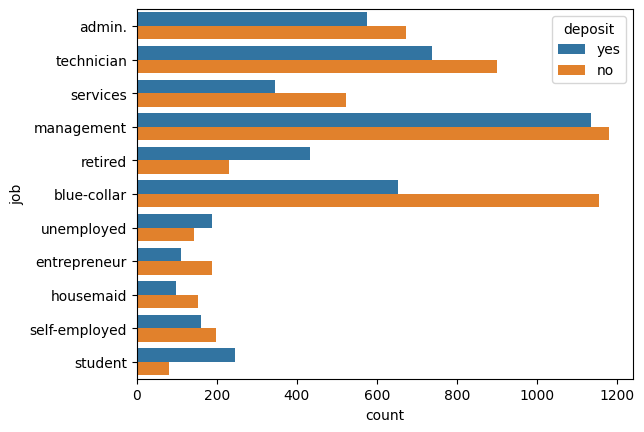

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y = 'job', hue='deposit', data=df)

### Задание 11

АНАЛИЗ ПЕРЕСЕЧЕНИЙ ОБРАЗОВАНИЯ И СЕМЕЙНОГО СТАТУСА
(среди клиентов, открывших депозит)
 Общая информация:
   • Всего клиентов в данных: 10105
   • Клиентов, открывших депозит: 4681
   • Доля открывших депозит: 46.32%

 СВОДНАЯ ТАБЛИЦА: ОБРАЗОВАНИЕ × СЕМЕЙНЫЙ СТАТУС
(количество клиентов, открывших депозит)
-----------------------------------------------------------------
marital    divorced  married  single   All
education                                 
primary          96      339      82   517
secondary       283     1289     879  2451
tertiary        174      784     755  1713
All             553     2412    1716  4681

 ПРОЦЕНТНОЕ РАСПРЕДЕЛЕНИЕ
(% от общего числа открывших депозит)
---------------------------------------------
marital    divorced  married  single
education                           
primary        2.05     7.24    1.75
secondary      6.05    27.54   18.78
tertiary       3.72    16.75   16.13

🎯 САМОЕ МНОГОЧИСЛЕННОЕ ПЕРЕСЕЧЕНИЕ:
------------------------------------

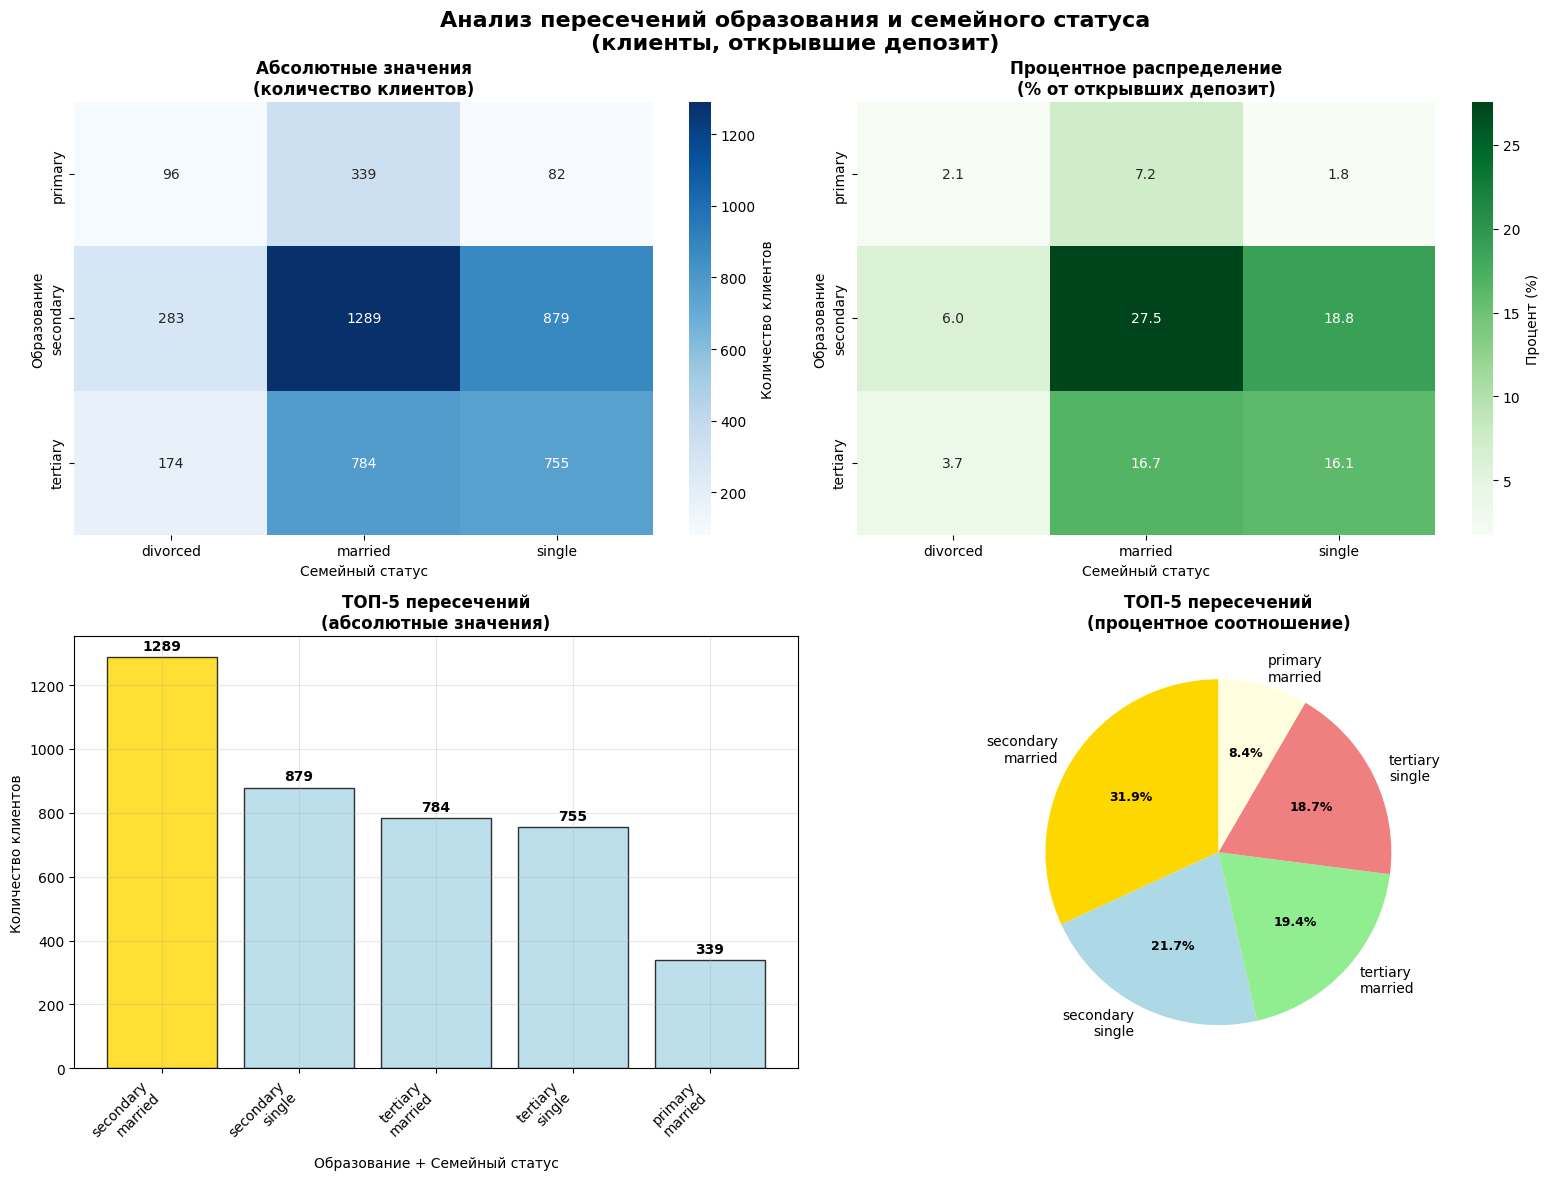

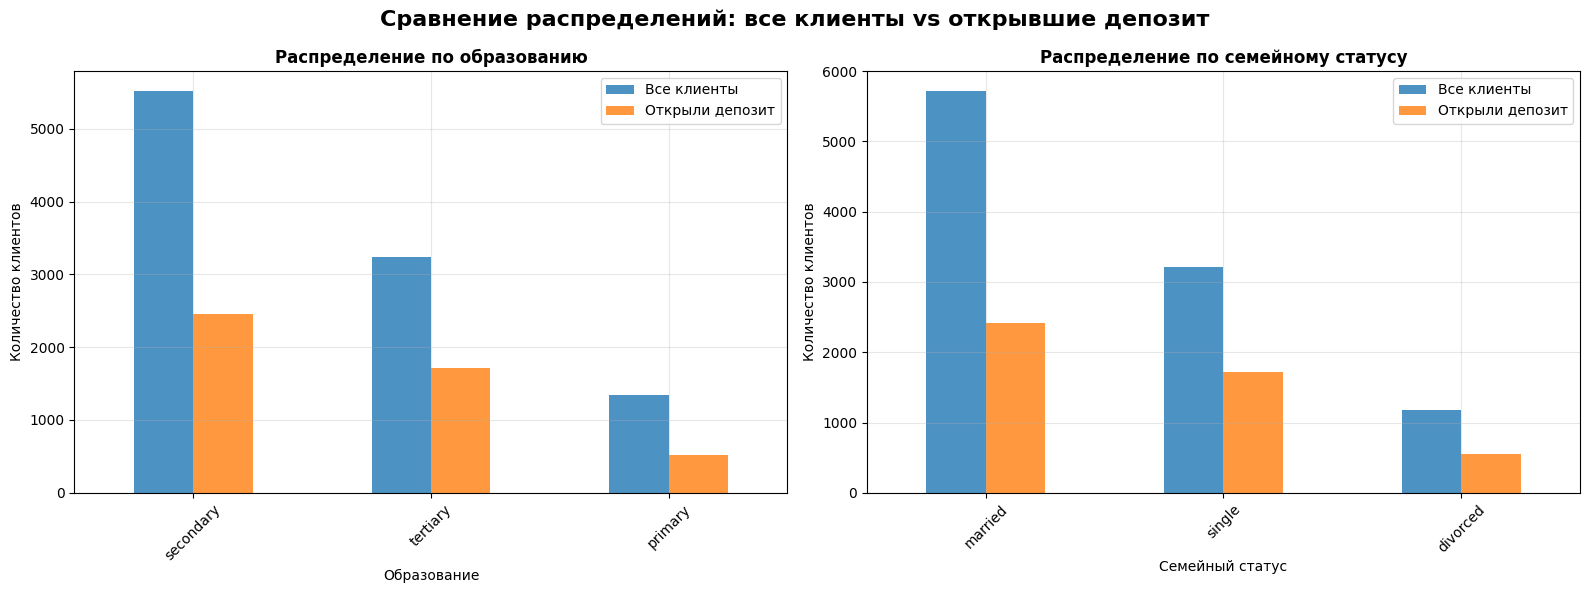

 СТАТИСТИЧЕСКИЙ АНАЛИЗ:
----------------------------------------
Хи-квадрат статистика: 142.5737
P-значение: 0.000000
Степени свободы: 4
 Связь между образованием и семейным статусом среди открывших депозит статистически значима

 БИЗНЕС-ВЫВОДЫ И РЕКОМЕНДАЦИИ:
---------------------------------------------
 Целевая группа №1: secondary образование + married
   • Размер сегмента: 1289 клиентов (27.5% от успешных)
   • Рекомендация: Приоритетный фокус маркетинговых кампаний

 Дополнительные приоритетные сегменты:
   2. secondary + single: 879 чел. (18.8%)
   3. tertiary + married: 784 чел. (16.7%)

 Концентрация ТОП-3 сегментов: 63.1% успешных клиентов
    Высокая концентрация - можно эффективно таргетировать

 ОТВЕТ:
Самое многочисленное пересечение категорий:
• ОБРАЗОВАНИЕ: secondary
• СЕМЕЙНЫЙ СТАТУС: married
• КОЛИЧЕСТВО КЛИЕНТОВ: 1289



In [19]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Проверяем наличие необходимых переменных
if all(col in df.columns for col in ['education', 'marital', 'deposit']):
    
    print("АНАЛИЗ ПЕРЕСЕЧЕНИЙ ОБРАЗОВАНИЯ И СЕМЕЙНОГО СТАТУСА")
    print("(среди клиентов, открывших депозит)")
    print("=" * 65)
    
    # Фильтруем данные - только те, кто открыл депозит
    deposit_clients = df[df['deposit'] == 'yes'].copy()
    
    print(f" Общая информация:")
    print(f"   • Всего клиентов в данных: {len(df)}")
    print(f"   • Клиентов, открывших депозит: {len(deposit_clients)}")
    print(f"   • Доля открывших депозит: {len(deposit_clients)/len(df)*100:.2f}%")
    print()
    
    # Создаем сводную таблицу (кросс-табуляцию)
    pivot_table = pd.crosstab(deposit_clients['education'], 
                             deposit_clients['marital'], 
                             margins=True)
    
    print(" СВОДНАЯ ТАБЛИЦА: ОБРАЗОВАНИЕ × СЕМЕЙНЫЙ СТАТУС")
    print("(количество клиентов, открывших депозит)")
    print("-" * 65)
    print(pivot_table)
    print()
    
    # Процентное распределение
    pivot_table_pct = pd.crosstab(deposit_clients['education'], 
                                 deposit_clients['marital'], 
                                 normalize='all') * 100
    
    print(" ПРОЦЕНТНОЕ РАСПРЕДЕЛЕНИЕ")
    print("(% от общего числа открывших депозит)")
    print("-" * 45)
    print(pivot_table_pct.round(2))
    print()
    
    # Находим самое многочисленное пересечение
    # Исключаем строку и столбец с итогами
    pivot_no_margins = pd.crosstab(deposit_clients['education'], deposit_clients['marital'])
    
    # Находим максимальное значение и его позицию
    max_value = pivot_no_margins.max().max()
    max_position = pivot_no_margins.stack().idxmax()
    max_education, max_marital = max_position
    
    print("🎯 САМОЕ МНОГОЧИСЛЕННОЕ ПЕРЕСЕЧЕНИЕ:")
    print("-" * 45)
    print(f" Образование: {max_education}")
    print(f" Семейный статус: {max_marital}")
    print(f" Количество клиентов: {max_value}")
    print(f" Доля от открывших депозит: {max_value/len(deposit_clients)*100:.2f}%")
    print(f" Доля от всех клиентов: {max_value/len(df)*100:.2f}%")
    print()
    
    # ТОП-5 пересечений
    print(" ТОП-5 САМЫХ МНОГОЧИСЛЕННЫХ ПЕРЕСЕЧЕНИЙ:")
    print("-" * 50)
    
    # Преобразуем в Series для сортировки
    combinations = pivot_no_margins.stack().sort_values(ascending=False)
    
    for i, ((education, marital), count) in enumerate(combinations.head().items(), 1):
        percentage = count / len(deposit_clients) * 100
        print(f"{i}. {education} + {marital}: {count} чел. ({percentage:.2f}%)")
    
    print()
    
    # Детальный анализ самого многочисленного пересечения
    print(" ДЕТАЛЬНЫЙ АНАЛИЗ САМОГО МНОГОЧИСЛЕННОГО ПЕРЕСЕЧЕНИЯ:")
    print("-" * 60)
    
    # Фильтруем данные для самого многочисленного пересечения
    target_group = df[(df['education'] == max_education) & (df['marital'] == max_marital)]
    target_group_deposits = target_group[target_group['deposit'] == 'yes']
    
    print(f" Группа: {max_education} образование + {max_marital}")
    print(f"   • Всего клиентов в этой группе: {len(target_group)}")
    print(f"   • Открыли депозит: {len(target_group_deposits)}")
    print(f"   • Не открыли депозит: {len(target_group) - len(target_group_deposits)}")
    print(f"   • Коэффициент открытия депозитов в группе: {len(target_group_deposits)/len(target_group)*100:.2f}%")
    print()
    
    # Дополнительная статистика по целевой группе
    if len(target_group) > 0:
        print(" Дополнительная статистика целевой группы:")
        
        # Средний возраст
        if 'age' in target_group.columns:
            avg_age = target_group['age'].mean()
            print(f"   • Средний возраст: {avg_age:.1f} лет")
        
        # Наиболее частые профессии
        if 'job' in target_group.columns:
            top_jobs = target_group['job'].value_counts().head(3)
            print(f"   • ТОП-3 профессии:")
            for job, count in top_jobs.items():
                percentage = count / len(target_group) * 100
                print(f"     - {job}: {count} чел. ({percentage:.1f}%)")
        
        print()
    
    # Создаем визуализации
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Анализ пересечений образования и семейного статуса\n(клиенты, открывшие депозит)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Тепловая карта сводной таблицы (абсолютные значения)
    sns.heatmap(pivot_no_margins, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                cbar_kws={'label': 'Количество клиентов'})
    axes[0, 0].set_title('Абсолютные значения\n(количество клиентов)', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Семейный статус')
    axes[0, 0].set_ylabel('Образование')
    
    # 2. Тепловая карта процентного распределения
    sns.heatmap(pivot_table_pct, annot=True, fmt='.1f', cmap='Greens', ax=axes[0, 1],
                cbar_kws={'label': 'Процент (%)'})
    axes[0, 1].set_title('Процентное распределение\n(% от открывших депозит)', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Семейный статус')
    axes[0, 1].set_ylabel('Образование')
    
    # 3. Столбчатая диаграмма ТОП-5 пересечений
    top_5_combinations = combinations.head()
    labels = [f"{edu}\n{mar}" for (edu, mar) in top_5_combinations.index]
    values = top_5_combinations.values
    
    colors = ['gold' if i == 0 else 'lightblue' for i in range(len(values))]
    bars = axes[1, 0].bar(range(len(values)), values, color=colors, alpha=0.8, edgecolor='black')
    
    axes[1, 0].set_title('ТОП-5 пересечений\n(абсолютные значения)', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Образование + Семейный статус')
    axes[1, 0].set_ylabel('Количество клиентов')
    axes[1, 0].set_xticks(range(len(values)))
    axes[1, 0].set_xticklabels(labels, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                       f'{value}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Круговая диаграмма ТОП-5 пересечений
    colors_pie = ['gold', 'lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    
    wedges, texts, autotexts = axes[1, 1].pie(values, 
                                             labels=[f"{edu}\n{mar}" for (edu, mar) in top_5_combinations.index],
                                             autopct='%1.1f%%',
                                             colors=colors_pie[:len(values)],
                                             startangle=90)
    
    axes[1, 1].set_title('ТОП-5 пересечений\n(процентное соотношение)', fontweight='bold', fontsize=12)
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    plt.tight_layout()
    plt.show()
    
    # Дополнительная визуализация - сравнение с общим распределением
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Сравнение распределений: все клиенты vs открывшие депозит', 
                 fontsize=16, fontweight='bold')
    
    # Распределение по образованию
    education_all = df['education'].value_counts()
    education_deposit = deposit_clients['education'].value_counts()
    
    comparison_education = pd.DataFrame({
        'Все клиенты': education_all,
        'Открыли депозит': education_deposit
    }).fillna(0)
    
    comparison_education.plot(kind='bar', ax=axes[0], alpha=0.8)
    axes[0].set_title('Распределение по образованию', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Образование')
    axes[0].set_ylabel('Количество клиентов')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Распределение по семейному статусу
    marital_all = df['marital'].value_counts()
    marital_deposit = deposit_clients['marital'].value_counts()
    
    comparison_marital = pd.DataFrame({
        'Все клиенты': marital_all,
        'Открыли депозит': marital_deposit
    }).fillna(0)
    
    comparison_marital.plot(kind='bar', ax=axes[1], alpha=0.8)
    axes[1].set_title('Распределение по семейному статусу', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Семейный статус')
    axes[1].set_ylabel('Количество клиентов')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Статистический анализ
    from scipy.stats import chi2_contingency
    
    chi2, p_value, dof, expected = chi2_contingency(pivot_no_margins)
    
    print(" СТАТИСТИЧЕСКИЙ АНАЛИЗ:")
    print("-" * 40)
    print(f"Хи-квадрат статистика: {chi2:.4f}")
    print(f"P-значение: {p_value:.6f}")
    print(f"Степени свободы: {dof}")
    
    if p_value < 0.05:
        print(" Связь между образованием и семейным статусом среди открывших депозит статистически значима")
    else:
        print(" Связь между образованием и семейным статусом среди открывших депозит статистически НЕ значима")
    
    print()
    
    # Бизнес-выводы
    print(" БИЗНЕС-ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
    print("-" * 45)
    print(f" Целевая группа №1: {max_education} образование + {max_marital}")
    print(f"   • Размер сегмента: {max_value} клиентов ({max_value/len(deposit_clients)*100:.1f}% от успешных)")
    print(f"   • Рекомендация: Приоритетный фокус маркетинговых кампаний")
    
    # ТОП-3 для дополнительного фокуса
    print(f"\n Дополнительные приоритетные сегменты:")
    for i, ((education, marital), count) in enumerate(combinations.head(3).items(), 1):
        if i == 1:  # Пропускаем первый, так как он уже описан выше
            continue
        percentage = count / len(deposit_clients) * 100
        print(f"   {i}. {education} + {marital}: {count} чел. ({percentage:.1f}%)")
    
    # Анализ концентрации
    top_3_total = combinations.head(3).sum()
    concentration = top_3_total / len(deposit_clients) * 100
    print(f"\n Концентрация ТОП-3 сегментов: {concentration:.1f}% успешных клиентов")
    
    if concentration > 50:
        print("    Высокая концентрация - можно эффективно таргетировать")
    else:
        print("     Низкая концентрация - нужна более широкая стратегия")
    
    print()
    
    #ОТВЕТ
    print(" ОТВЕТ:")
    print("=" * 40)
    print(f"Самое многочисленное пересечение категорий:")
    print(f"• ОБРАЗОВАНИЕ: {max_education}")
    print(f"• СЕМЕЙНЫЙ СТАТУС: {max_marital}")
    print(f"• КОЛИЧЕСТВО КЛИЕНТОВ: {max_value}")
    print("=" * 40)

else:
    print(" Не найдены необходимые переменные: 'education', 'marital', 'deposit'")

print("\n" + "=" * 65)

## Часть 3: преобразование данных

### Задание 1

In [20]:
# преобразуйте уровни образования
# создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df['education'] = lab_enc.fit_transform(df['education'])

#подсчет
education_sum = df['education'].sum()
print(f"Сумма значений признака 'education': {education_sum}")

Сумма значений признака 'education': 11995


### Задания 2 и 3

In [21]:
# преобразуйте бинарные переменные в представление из нулей и единиц

# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

#Кодировка признака
df['age_group'] = lab_enc.fit_transform(df['age_group'])

In [22]:
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.

# перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.
df['deposit'] = df['deposit'].replace({'yes': 1, 'no': 0})
df['deposit'].describe()

count    10105.000000
mean         0.463236
std          0.498671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: deposit, dtype: float64

In [23]:
# Сделаем то же самое для других бинарных переменных, которых у нас три: 'default'; 'housing'; 'loan'. Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.
df['default'] = df['default'].replace({'yes': 1, 'no': 0})
df['housing'] = df['housing'].replace({'yes': 1, 'no': 0})
df['loan'] = df['loan'].replace({'yes': 1, 'no': 0})

answer_4_3 = df['default'].mean() + df['housing'].mean() + df['loan'].mean()
print(answer_4_3)

0.6354280059376547


In [24]:
df.shape

(10105, 18)

### Задание 4

In [25]:
# Создание dummy-переменных для номинальных признаков
nominal_variables = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создаем dummy-переменные для каждой переменной
dummies_list = []
for var in nominal_variables:
    if var in df.columns:
        dummies = pd.get_dummies(df[var], prefix=var, drop_first=False)
        dummies_list.append(dummies)

# Объединяем все dummy-переменные с основным DataFrame
if dummies_list:
    all_dummies = pd.concat(dummies_list, axis=1)
    df = pd.concat([df, all_dummies], axis=1)

print(f"Размер DataFrame после создания dummy-переменных: {df.shape}")

Размер DataFrame после создания dummy-переменных: (10105, 51)


### Задания 5 и 6

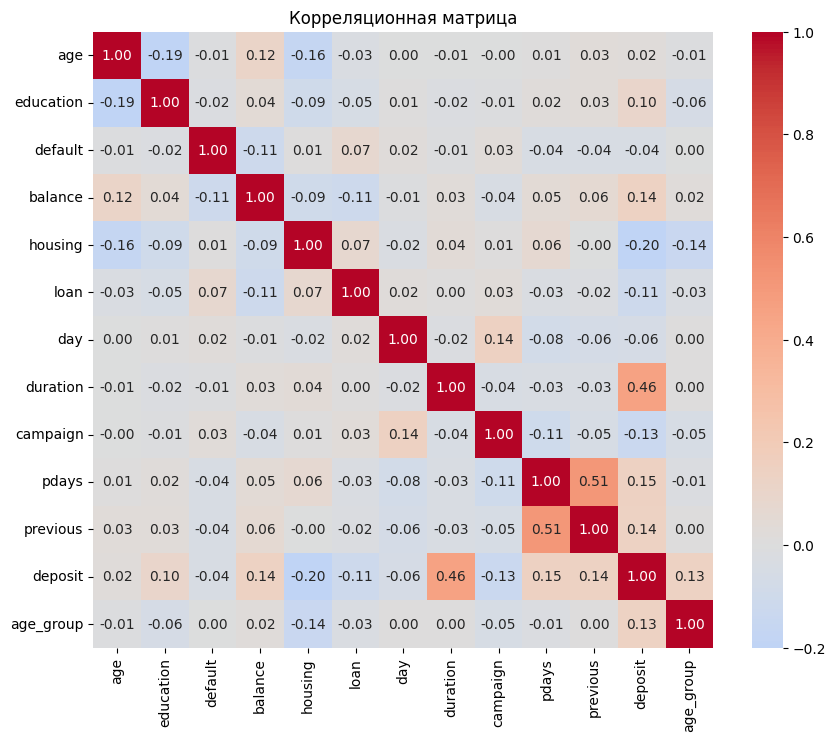

In [26]:
# Тепловая карта корреляций числовых признаков
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

In [27]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,...,False,False,False,False,False,False,False,False,False,True
11158,39,services,married,1,0,733.0,0,0,unknown,16,...,True,False,False,False,False,False,False,False,False,True
11159,32,technician,single,1,0,29.0,0,0,cellular,19,...,False,False,False,False,False,False,False,False,False,True
11160,43,technician,married,1,0,0.0,0,1,cellular,8,...,False,False,True,False,False,False,True,False,False,False


### Задания 7 и 8

In [28]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [29]:
# рассчитайте необходимые показатели

### Задание 9

In [30]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [31]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [32]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [33]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [34]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [35]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [36]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [37]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [38]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [39]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna